In [1]:
import re
import os
import pathlib
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme(style="darkgrid")

# Root of the project
project_dir = pathlib.Path().resolve().parent

# Directory containing experiment results
results_dir = (pathlib.Path(project_dir) / "results").resolve()

# Directory for tidied data (output directory)
data_dir = (pathlib.Path(project_dir) / "data").resolve()

# Directory to store all plots
plot_dir = (pathlib.Path(project_dir) / "plots").resolve()



# Experiment constants
exp_name = "01_http_max_throughput"
file_prefix = "exp-01"

In [2]:
"""Load cleaned/aggregated data sets

Also fixes type hinting for pandas

resource_df -> CPU/Mem utilization for experiments
fortio_df -> Load test results from fortio
"""

resource_df = pd.read_csv(
    data_dir / "resource_results.feather",
    dtype={
        # "experiment": "category",
        # "mesh": "category",
        # "requested_qps": "category",
        "pod": "string",
        "container": "string",
    },
    parse_dates=["date"],
)


fortio_df = pd.read_feather(
    data_dir / "fortio_results.feather",
    # dtype={
    #     # "experiment": "category",
    #     # # "mesh": "category",
    #     # "requested_qps": "category",
    #     # "protocol": "category",
    #     # "payload": "category",
    #     "actual_qps": "float64",
    #     "latency": "float64",
    # },
    # parse_dates=["date"],
)

In [3]:
"""
Prepares the experiment data

"""


exp = fortio_df[fortio_df["experiment"] == "01_http_max_throughput"]
exp = exp.drop("actual_qps", 1)
exp = exp.explode("latency")
exp = exp.reset_index(drop=True)
exp = exp.astype({
    "latency": np.float64
})

exp = exp.sort_values("mesh", ascending=True)


exp.head()

,experiment,mesh,requested_qps,protocol,payload,latency
39588490,01_http_max_throughput,Baseline,MAX,http,0,1.212712
41873570,01_http_max_throughput,Baseline,MAX,http,0,1.552183
41873569,01_http_max_throughput,Baseline,MAX,http,0,1.412421
41873568,01_http_max_throughput,Baseline,MAX,http,0,1.476801
41873567,01_http_max_throughput,Baseline,MAX,http,0,1.567548


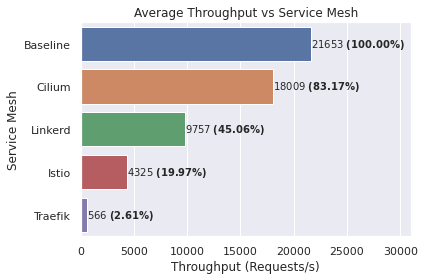

In [54]:
"""
PLOT: Bar Chart
Desc: Average Throughput per service mesh
"""

file_name = f"{file_prefix}-bar_avg_throughput.pdf"

data =  fortio_df[fortio_df["experiment"] == "01_http_max_throughput"]
data = data.sort_values("actual_qps", ascending=False)


fig, ax = plt.subplots()
ax = sns.barplot(data=data, x="actual_qps", y="mesh", ax=ax)

ax.set_xlim(0, 31000)


# # Show numbers on top of bars
labels = [f"{x:.0f} $\\bf({x / data['actual_qps'].max() * 100:.2f}\%)$" for x in data["actual_qps"]]

ax.bar_label(ax.containers[0], labels=labels, label_type="edge")


ax.set_xlabel("Throughput (Requests/s)")
ax.set_ylabel("Service Mesh")
ax.set_title("Average Throughput vs Service Mesh")




fig.tight_layout()
fig.savefig(plot_dir / file_name)


In [43]:
x = list(data["actual_qps"])
m = data["actual_qps"].max()

for d in x:
    p = (d / m) * 100
    print(f"percentage: {p}% - {d}")
    


percentage: 100.0% - 21652.916972159983
percentage: 83.1723202305133% - 18009.233443332065
percentage: 45.05900612649719% - 9756.589185050916
percentage: 19.973585701822405% - 4324.863928378823
percentage: 2.61307869786235% - 565.8077608653339


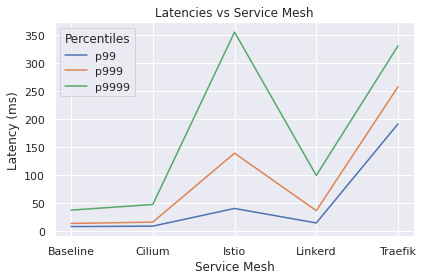

In [8]:
"""
PLOT: Line Plot
Desc: Tail end latencies (high percentiles)
"""

file_name = f"{file_prefix}-line_tail_latencies.pdf"

# The quantiles to plot
quantiles = [
    0.99,
    0.999,
    0.9999
]
data = exp.groupby("mesh")["latency"].quantile(quantiles).unstack()

fig, ax = plt.subplots()
ax = sns.lineplot(data=data, dashes=False, ax=ax)

ax.set_xlabel("Service Mesh")
ax.set_ylabel("Latency (ms)")

ax.set_title("Latencies vs Service Mesh")

ax.legend(["p99", "p999", "p9999"], title= "Percentiles")

fig.tight_layout()
fig.savefig(plot_dir / file_name)

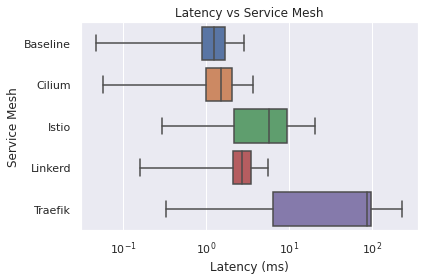

In [9]:
"""
PLOT: Boxplot latency by mesh
Desc: Show 25p med 50p latencies
"""

file_name = f"{file_prefix}-box_latency-log.pdf"
plot_title = "Latency vs Service Mesh"

fig, ax = plt.subplots()
data = exp[exp["mesh"] == "Traefik"]
data = data.sort_values("mesh")
ax = sns.boxplot(data=exp, x="latency", y="mesh", showfliers=False)

# Labels
ax.set_ylabel("Service Mesh")
ax.set_xlabel("Latency (ms)")
ax.set_title(plot_title)

ax.set_xscale("log")


fig.tight_layout()
fig.savefig(plot_dir / file_name)

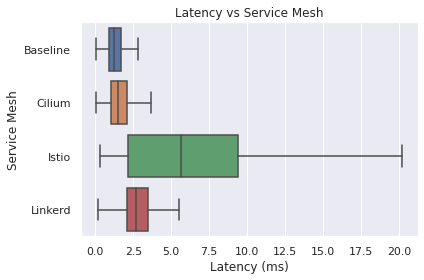

In [10]:
"""
PLOT: Boxplot latency by mesh
Desc: Show 25p med 50p latencies without traefik
"""

file_name = f"{file_prefix}-box_latency-no-traefik.pdf"
plot_title = "Latency vs Service Mesh"

data = exp[exp["mesh"] != "Traefik"]
data = data.sort_values("mesh")

fig, ax = plt.subplots()
ax = sns.boxplot(data=data, x="latency", y="mesh", showfliers=False)

# Labels
ax.set_ylabel("Service Mesh")
ax.set_xlabel("Latency (ms)")
ax.set_title(plot_title)

# ax.set_xscale("log")


fig.tight_layout()
fig.savefig(plot_dir / file_name)

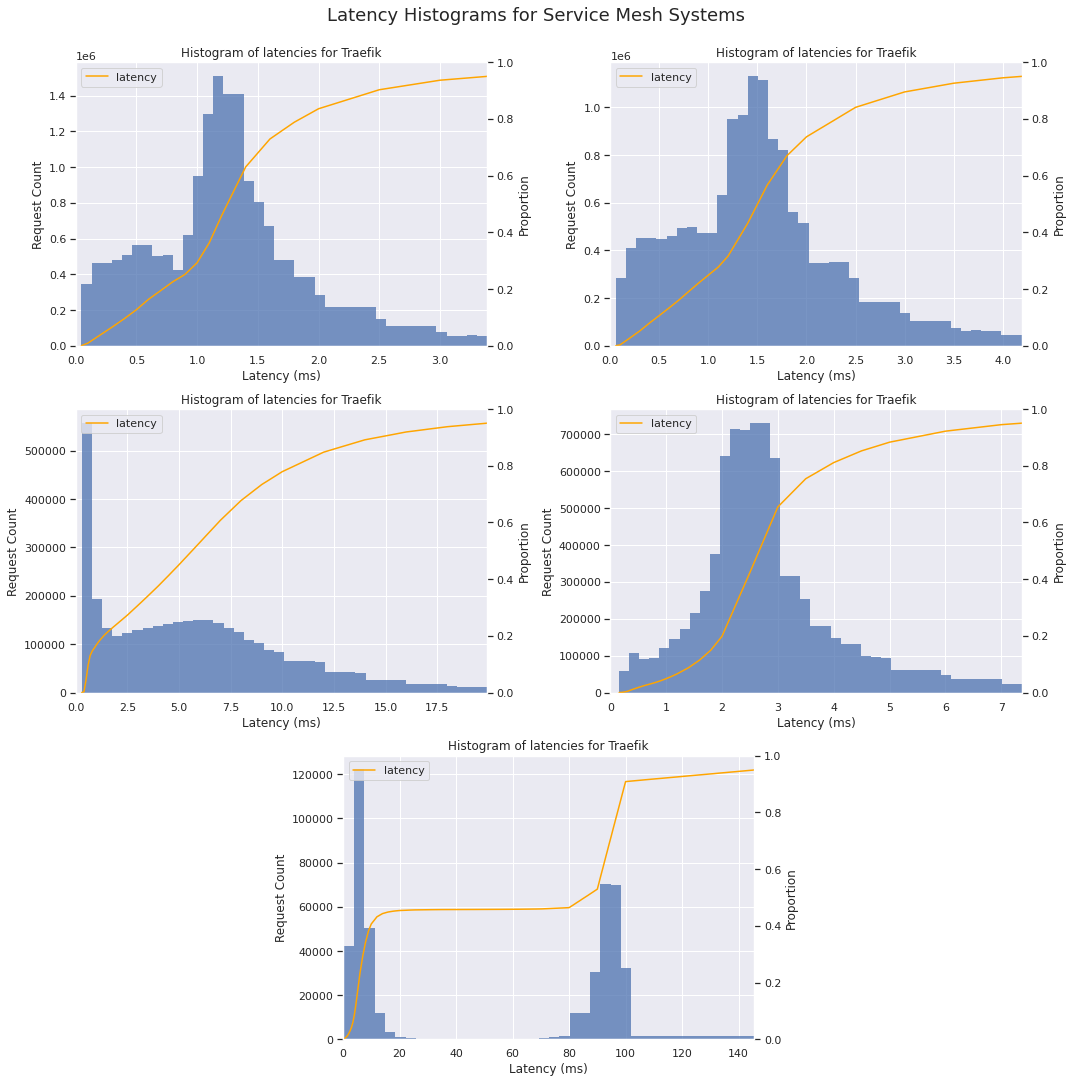

In [22]:

"""
PLOT: Histogram plots
Desc: 
"""

file_name = f"{file_prefix}-hist_latencies.pdf"

# Create grid of plots
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(nrows=3, ncols=4)

# Create subplots, each plot is 2 cols wide
axes=[
    # Row 0
    fig.add_subplot(gs[0, 0:2]),
    fig.add_subplot(gs[0, 2:4]),
    # Row 1 
    fig.add_subplot(gs[1, 0:2]),
    fig.add_subplot(gs[1, 2:4]),
    # Row 2 (offset by 1)
    fig.add_subplot(gs[2, 1:3]),
]

# Set figure title
fig.suptitle("Latency Histograms for Service Mesh Systems", fontsize=18, y=1)

mesh_configs = exp["mesh"].unique()

for i, m in enumerate(mesh_configs):
    data = exp[exp["mesh"] == m]
    # filtered = data[data["latency"] < data["latency"].quantile(.95)]

    quant = data["latency"].quantile(.95)
    min = data["latency"].min()
    bins = 40
    binwidth = (quant - min) / bins

    ax = axes[i]

    sns.histplot(data=data, x="latency", binwidth=binwidth, ec="none", ax=ax)

    # Labels
    # plot_title = (
    #     f"$\\bf{row['mesh'].capitalize()}$\n"
    #     f"RPS: {row['ActualQPS']:.0f}\n"
    #     f"min: {row['Min']:.2f} ms, avg: {row['Avg']:.2f} ms, max: {row['Max']:.2f} ms"
    # )
    ax.set_ylabel("Request Count")
    ax.set_xlabel("Latency (ms)")
    ax.set_title("Histogram of latencies for Traefik")


    # Y AXIS
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())


    # X AXIS
    ax.set_xlim(0, quant)
    # ax.set_xscale("log")
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())


    # Second plot with cumulative density
    ax2 = ax.twinx()
    ax2.set_alpha(0.5)
    ax2.grid(False)
    sns.ecdfplot(data=data, palette=["orange"], ax=ax2)


fig.tight_layout()
fig.savefig(plot_dir / file_name)

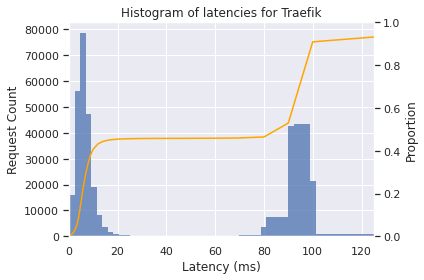

In [19]:
"""
PLOT: Histplot of Traefik mesh
Desc: Shows bimodal nature of traefik mesh latencies
"""

file_name = f"{file_prefix}-hist-traefik.pdf"

data = exp[exp["mesh"] == "Traefik"]

fig, ax = plt.subplots()
sns.histplot(data=data, x="latency", ec="none", ax=ax)

ax.set_ylabel("Request Count")
ax.set_xlabel("Latency (ms)")
ax.set_title("Histogram of latencies for Traefik")


# Y AXIS
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())


# X AXIS
ax.set_xlim(0, 125)
# ax.set_xscale("log")
# ax.xaxis.set_major_formatter(ticker.ScalarFormatter())


# Second plot with cumulative density
ax2 = ax.twinx()
ax2.set_alpha(0.5)
ax2.grid(False)
sns.ecdfplot(data=data, palette=["orange"], ax=ax2)
ax2.get_legend().remove()

fig.tight_layout()
fig.savefig(plot_dir / file_name)

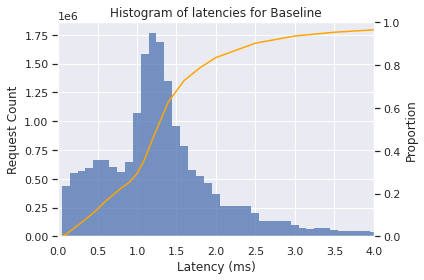

In [15]:
"""
PLOT: Histplot of Traefik mesh
Desc: Shows normal distribution of latencies
"""

file_name = f"{file_prefix}-hist-baseline.pdf"

data = exp[exp["mesh"] == "Baseline"]

fig, ax = plt.subplots()
sns.histplot(data=data, x="latency", binwidth=.1, ec="none", ax=ax)

ax.set_ylabel("Request Count")
ax.set_xlabel("Latency (ms)")
ax.set_title("Histogram of latencies for Baseline")


# Y AXIS
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())


# X AXIS
ax.set_xlim(0, 4)
# ax.set_xscale("log")
# ax.xaxis.set_major_formatter(ticker.ScalarFormatter())


# Second plot with cumulative density
ax2 = ax.twinx()
ax2.set_alpha(0.5)
ax2.grid(False)
sns.ecdfplot(data=data, palette=["orange"], ax=ax2)
ax2.get_legend().remove()

fig.tight_layout()
fig.savefig(plot_dir / file_name)